<a href="https://colab.research.google.com/github/pena-rodrigo/Dino-Name-Generator/blob/main/dino-name.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing modules

In [44]:
import os
import time
import math
import string
import random

In [45]:
import collections
import numpy as np
import matplotlib.pyplot as plt

In [46]:
import torch
from torch import nn
from torch import optim
from torch.functional import F
from torch.utils.data import DataLoader

In [47]:
from google.colab import drive
drive.mount('/content/gdrive')
dir = '/content/gdrive/MyDrive/Dino-Name-Generator-main/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [48]:
import os
import time
import math
import string
import random

import collections
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.functional import F



def train(model, data, num_iter, criterion, clip=0.25, lr=0.001, print_every=50,
    sleep=False, sleep_every=None):
    """
    Input:
        model: A Pytorch's nn.Module class.
        data: Training data, containing both x and y.
        num_iter: Number of time to perform backward prop, (update parameters).
        criterion: A function that takes in (out, y) and returns the loss.
        clip: Value to clip gradients to. If None, clipping is not done.
        lr: Learning rate.
        print_every: Number of iterations to print averaged loss. If None, nothing
            is printed.
        sleep: Number of seconds to pause training.
        sleep_every: Number of iterations to pause training. Ignored if sleep is False.
    
    Output:
        model: The trained model.
        costs: List of all the calculated loss.
    """
    model.train()
    
    costs = []
    running_loss = 0
    optimizer = optim.Adam(model.parameters(), lr=lr)

    curr_iter = 0
    while curr_iter<num_iter:
        for x, y in data:
            optimizer.zero_grad()
            
            # Initialise model's state and perform forward-prop
            if isinstance(x, (list, tuple)):
                prev_state = model.init_state(b_size=x[0].shape[0])
            else:
                prev_state = model.init_state(b_size=x.shape[0])

            out, state = model(x, prev_state)

            # Calculate loss
            loss = criterion(out.transpose(1, 2), y)
            costs.append(loss.item())
            running_loss += loss.item()

            # Calculate gradients and update parameters
            loss.backward()
            if clip:
                nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            
            curr_iter += 1
            if print_every and (curr_iter%print_every)==0:
                print("Iteration: {:{}}/{}, Loss: {:8.4f}".format(
                    curr_iter, int(math.log(num_iter, 10))+2, num_iter,
                    running_loss/float(print_every)))
                running_loss = 0
                
            if curr_iter>=num_iter:
                break

            if (sleep and sleep_every) and (curr_iter%sleep_every)==0:
                time.sleep(sleep)
    return model, costs

In [49]:
import os
import time
import math
import string
import random

import collections
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.functional import F



def test_dataset_batching(x, y, xlen=None):
    """
        Test if x[1:] == y[:-1]. Both x and y are without padding.

    Input:
        x: Batch of x.
        y: Batch of y.
        xlen: True length of each sample in the batch.
        
    Example:
        
        # Assuming dataloader is the same as in the notebook dino-name_batch.ipynb
        >>> for d in dataloader:
        ...     test_dataset_batching(d[0][0], d[1], d[0][1])
    """
    count = 0
    for i, (xi, yi) in enumerate(zip(x, y)):
        xi_nopad = xi[:xlen[i]] if xlen is not None else xi
        yi_nopad = yi[:xlen[i]] if xlen is not None else yi
        
        if (xi_nopad[1:] == yi_nopad[:-1]).all():
            count += 1
    print("{} of {} indexes passed test.".format(count, i+1))


def test_model_batch_vs_nobatch(model, data, pad_ix=-100, e=1e-4):
    """
        Test if model's output, state and loss is the same for batch and nobatch.

    Input:
        model: A Pytorch's nn.Module class.
        data: ((x, xlen), y).
        pad_ix: PAD token index. An error might be raised if it is not given.
        e: Precision of comparision. The default value is recommended.
        
    Example:
        
        # Assuming dataloader is the same as in the notebook dino-name_batch.ipynb
        >>> for d in dataloader:
        ...     test_model_batch_vs_nobatch(model, d, char_to_ix["<PAD>"])
    """
    x, y = data
    n_b, n_s = x[0].shape

    count = {"out": 0, "state": 0, "loss": 0}
    criterion = nn.CrossEntropyLoss(reduction="none", ignore_index=pad_ix)
    
    # BATCHING: Perform forward-pass with gradient calculation disabled
    model.eval()
    with torch.no_grad():
        batch_out, batch_state = model(x, model.init_state(n_b))
        batch_state = torch.cat(batch_state).transpose(0, 1)
        batch_loss = criterion(batch_out.transpose(1, 2), y)
        
    # NO-BATCHING
    for i in range(n_b):
        xlen_i = int(x[1][i])

        xi = (x[0][i][:xlen_i].unsqueeze(0), x[1][i].unsqueeze(0))
        yi =     y[i][:xlen_i].unsqueeze(0)
        
        # Perform forward-pass with gradient calculation disabled
        model.eval()
        with torch.no_grad():
            nobatch_out_i, nobatch_state_i = model(xi, model.init_state(1))
            nobatch_state_i = torch.cat(nobatch_state_i).transpose(0, 1)
            nobatch_loss_i = criterion(nobatch_out_i.transpose(1, 2), yi)

        # NOTE: Each of the comparision below are calculated upto a certain precision e,
        # due to issues arising from early rounding and floating-point precision

        # check if model outputs are equal
        if ((batch_out[i][:xlen_i] - nobatch_out_i) < e).all():
            count["out"] += 1

        # check if model hidden states are equal
        if ((batch_state[i][:xlen_i] - nobatch_state_i) < e).all():
            count["state"] += 1

        # check if model loss are equal
        if ((batch_loss[i][:xlen_i] - nobatch_loss_i) < e).all():
            count["loss"] += 1

    print("Out: {out}/{n_b} match; State: {state}/{n_b} match; Loss: {loss}/{n_b} match."
        .format(n_b=n_b, **count))


In [50]:
import os
import time
import math
import string
import random

import collections
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.functional import F



def sample_next(model, x, prev_state, topk=5, uniform=True):
    """
    Input:
        model: A Pytorch's nn.Module class.
        x: The input to the model.
        prev_state: The previous state of the model.
        topk: The top-k output to sample from. If None, sample from the entire output.
        uniform: Whether to sample from a uniform or a weighted distrubution of topk.
    
    Output:
        sampled_ix: The sampled index.
        state: The current state of the model.
    """
    # Perform forward-prop and get the output of the last time-step
    out, state = model(x, prev_state)
    last_out = out[0, -1, :]

    # Get the top-k indexes and their values
    topk = topk if topk else last_out.shape[0]
    top_logit, top_ix = torch.topk(last_out, k=topk, dim=-1)
    
    # Get the softmax of the topk's and sample
    p = None if uniform else F.softmax(top_logit.detach(), dim=-1).numpy()
    sampled_ix = np.random.choice(top_ix, p=p)
    return sampled_ix, state


def sample(model, seed, topk=5, uniform=True, max_seqlen=18, stop_on=None, batched=True):
    """
    Input:
        model: A Pytorch's nn.Module class.
        seed: List of indexes to intialise model with.
        topk: The top-k output to sample from. If None, sample from the entire output.
        uniform: Whether to sample from a uniform or a weighted distrubution of topk.
        max_seqlen: The maximum sequence length to sample. 'seed' length is included.
        stop_on: Index that signals the end of sequence (sampling).
            If None, max_seqlen determines the end of sampling.
    
    Output:
        sampled_ix_list: List of sampled indexes.
    """
    seed = seed if isinstance(seed, (list, tuple)) else [seed]
    
    model.eval()
    with torch.no_grad():
        sampled_ix_list = seed[:]
        x = (torch.tensor([seed]), torch.tensor([len(seed)]))
        if not batched:
            x = torch.tensor([seed])
        
        prev_state = model.init_state(b_size=1)
        for t in range(max_seqlen - len(seed)):
            sampled_ix, prev_state = sample_next(model, x, prev_state, topk, uniform)

            sampled_ix_list.append(sampled_ix)
            x = (torch.tensor([[sampled_ix]]), torch.tensor([1]))
            if not batched:
                x = torch.tensor([[sampled_ix]])
            
            if sampled_ix==stop_on:
                break
    
    model.train()
    return sampled_ix_list


def originality(n_samp, corpus, sampler, model, ix_list, *args, **kwargs):
    """
    Input:
        n_samp: Number of samples to consider.
        corpus: List of training examples of the format outputted by sampler.
        sampler: A function that returns a list of sampled indexes. Must take in
            model and a (list of) seed as it's first two arguments.
        model: A Pytorch's nn.Module class.
        ix_list: List of seed index, from vocab, to consider.

        *arg: Arguments to pass with sampler.
        **kwargs: Keyword arguments to pass with sampler.
    
    Output:
        samples: List of samples that were considered.
        duplicates: List of samples that are in corpus.
    """
    samples = []
    duplicates = []
    
    for i in range(n_samp):
        samp = sampler(model, random.choice(ix_list), *args, **kwargs)
        samples.append(samp)

        if samp in corpus:
            duplicates.append(samp)

    recall = 100 * len(duplicates) / n_samp
    print("Duplicates: {} of {}".format(len(duplicates), n_samp))
    print("{:6.2f}% recall".format(recall))
    print("{:6.2f}% original".format(100 - recall))
    return samples, duplicates


def keys_to_values(keys, _map, default):
    """
        Converts values in keys to their mapped values in _map. If not found,
        default is used instead.
    """
    return [_map.get(key, default) for key in keys]


In [51]:
# import evaluate.py
# import training.py

In [52]:
from importlib import reload

In [53]:
dir+"clean_names.pt"

'/content/gdrive/MyDrive/Dino-Name-Generator-main/clean_names.pt'

## Loading data

In [54]:
data_dict_re = torch.load(dir+"clean_names.pt")

In [55]:
data_in_char = data_dict_re["data_in_char"]
char_vocab = data_dict_re["char_vocab"]

**NOTE:** `char_vocab` contains a **PAD token** which is meant for when we want to batch our training data. We are not doing that here, so we are removing it.

In [56]:
if "<PAD>" in char_vocab:
    char_vocab.remove("<PAD>")

In [57]:
print("data length:", len(data_in_char))
print("vocab size:", len(char_vocab))

data length: 1545
vocab size: 27


In [58]:
print(data_in_char[:5])

[['a', 'a', 'c', 'h', 'e', 'n', 'o', 's', 'a', 'u', 'r', 'u', 's', '<EOS>'], ['a', 'a', 'r', 'd', 'o', 'n', 'y', 'x', '<EOS>'], ['a', 'b', 'd', 'a', 'l', 'l', 'a', 'h', 's', 'a', 'u', 'r', 'u', 's', '<EOS>'], ['a', 'b', 'e', 'l', 'i', 's', 'a', 'u', 'r', 'u', 's', '<EOS>'], ['a', 'b', 'r', 'i', 'c', 't', 'o', 's', 'a', 'u', 'r', 'u', 's', '<EOS>']]


In [59]:
char_to_ix = {ch:i for i,ch in enumerate(char_vocab)}
ix_to_char = {i:ch for ch,i in char_to_ix.items()}

In [62]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_as_str, _map):
        self.data_as_int = []
        self.max_seqlen = float("-inf")
        self.min_seqlen = float("inf")
        
        # Convert characters to integers
        for seq_as_str in data_as_str:
            seq_as_int = keys_to_values(seq_as_str, _map,
                random.choice(list(_map)))
            
            self.data_as_int.append(seq_as_int)
            self.max_seqlen = max(self.max_seqlen, len(seq_as_int)-1)
            self.min_seqlen = min(self.min_seqlen, len(seq_as_int)-1)

    def __len__(self):
        return len(self.data_as_int)

    def __getitem__(self, ix):
        # Get data sample at index ix
        item = self.data_as_int[ix]
        
        # Slice x and y from sample
        x = item[:-1]
        y = item[ 1:]
        
        return torch.tensor(x), torch.tensor(y)

In [63]:
dataset = Dataset(data_in_char, char_to_ix)
dataloader = DataLoader(dataset, 1, True)

In [64]:
print("Dataset size:", len(dataset))
print("Max sequence length:", dataset.max_seqlen)
print("Min sequence length:", dataset.min_seqlen)

Dataset size: 1545
Max sequence length: 23
Min sequence length: 3


## Model

In [65]:
class Model(nn.Module):
    def __init__(self, _map, hidden_size, emb_dim=8, n_layers=1, dropout_p=0.2):
        """
        Input:
            _map: char_to_ix.
            hidden_size: Number of features to learn.
            emb_dim: Size of embedding vector.
            n_layers: Number of layers.
            dropout_p: Dropout probability.
        """
        super(Model, self).__init__()
        
        self.vocab_size  = len(_map)
        self.hidden_size = hidden_size
        self.emb_dim     = emb_dim
        self.n_layers    = n_layers
        self.dropout_p   = dropout_p
        
        self.embedding = nn.Embedding(
            num_embeddings=self.vocab_size,
            embedding_dim =self.emb_dim)
        
        self.lstm = nn.LSTM(
            input_size =self.emb_dim,
            hidden_size=self.hidden_size,
            num_layers =self.n_layers,
            batch_first=True)
        
        self.dropout = nn.Dropout(self.dropout_p)
        
        self.fc = nn.Linear(
            in_features =self.hidden_size,
            out_features=self.vocab_size)
        
    def forward(self, x, prev_state):
        """
        Input:
            x: x
            prev_state: The previous state of the model.
            
        Output:
            out: The output of the model.
            state: The current state of the model.
        """
        n_b, n_s = x.shape
        
        embed = self.embedding(x)
        yhat, state = self.lstm(embed, prev_state)
        
        yhat = self.dropout(yhat)
        out = self.fc(yhat)
        return out, state
    
    def init_state(self, b_size=1):
        return (torch.zeros(self.n_layers, b_size, self.hidden_size),
                torch.zeros(self.n_layers, b_size, self.hidden_size))

In [66]:
model = Model(char_to_ix, 64, 8, n_layers=1, dropout_p=0.2)
model

Model(
  (embedding): Embedding(27, 8)
  (lstm): LSTM(8, 64, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=27, bias=True)
)

In [67]:
loss_history = []

## Loading and Saving Model

In [68]:
def load_model(path):
    m_data = torch.load(path)
    
    m = Model(
        _map       =m_data["_map"],
        hidden_size=m_data["hidden_size"],
        emb_dim    =m_data["emb_dim"],
        n_layers   =m_data["n_layers"],
        dropout_p  =m_data["dropout_p"])
    
    m.load_state_dict(m_data["state_dict"])
    l_hist = m_data["loss_history"]
    return m, l_hist

**Uncomment cell to load the trained model**

In [69]:
# model, loss_history = load_model("./saves/model/dino-name.pt")
# model

In [74]:
def save_model(m, l_hist, _map, path=None):
    if not path: path = dir+"./saves/model/dino-name.pt"
        
    m_data = {
        "_map"        : _map,
        "hidden_size" : m.hidden_size,
        "emb_dim"     : m.emb_dim,
        "n_layers"    : m.n_layers,
        "dropout_p"   : m.dropout_p,
        "state_dict"  : m.state_dict(),
        "loss_history": l_hist}
    torch.save(m_data, path)

## Training

In [75]:
criterion = nn.CrossEntropyLoss()

In [76]:
iteration = 50000
per_iter = 5000
start_t = time.time()

for _ti in range(iteration//per_iter):
    model, costs = train(
        model, dataloader, per_iter, criterion, clip=0.25, lr=1e-3, print_every=1000)
    
    loss_history.extend(costs)
    save_model(model, loss_history, char_to_ix)
    time.sleep(5)
    
    print("\n" + "="*50)
    print("Round: {:2} of {:2}, Running Time: {:7.2f} sec".format(
        _ti+1, iteration//per_iter, time.time() - start_t))
    print("="*50 + "\n")

Iteration:  1000/5000, Loss:   1.7089
Iteration:  2000/5000, Loss:   1.6379
Iteration:  3000/5000, Loss:   1.6280
Iteration:  4000/5000, Loss:   1.6102
Iteration:  5000/5000, Loss:   1.5819

Round:  1 of 10, Running Time:   25.32 sec

Iteration:  1000/5000, Loss:   1.5502
Iteration:  2000/5000, Loss:   1.5665
Iteration:  3000/5000, Loss:   1.5385
Iteration:  4000/5000, Loss:   1.4879
Iteration:  5000/5000, Loss:   1.5250

Round:  2 of 10, Running Time:   49.86 sec

Iteration:  1000/5000, Loss:   1.4923
Iteration:  2000/5000, Loss:   1.4833
Iteration:  3000/5000, Loss:   1.4558
Iteration:  4000/5000, Loss:   1.4529
Iteration:  5000/5000, Loss:   1.4251

Round:  3 of 10, Running Time:   74.24 sec

Iteration:  1000/5000, Loss:   1.4364
Iteration:  2000/5000, Loss:   1.3890
Iteration:  3000/5000, Loss:   1.4159
Iteration:  4000/5000, Loss:   1.3889
Iteration:  5000/5000, Loss:   1.3732

Round:  4 of 10, Running Time:   99.03 sec

Iteration:  1000/5000, Loss:   1.3544
Iteration:  2000/5000,

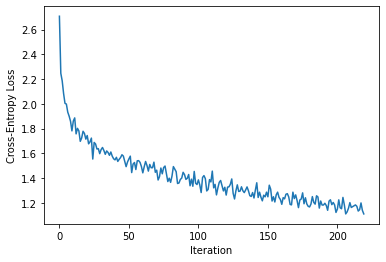

In [77]:
cum = 250
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy Loss")
plt.plot(
    [sum(loss_history[i:i+cum])/cum for i in range(0, len(loss_history), cum)])

In [78]:
print("Iter: {} | Min: {:.4f} | Max: {:.4f} | Last: {:.4f} | Ave: {:.4f}".format(
    len(loss_history), min(loss_history), max(loss_history), loss_history[-1],
    sum(loss_history)/len(loss_history)))

Iter: 55000 | Min: 0.2338 | Max: 4.8416 | Last: 0.5642 | Ave: 1.4048


## Evaluating

In [80]:
n_samp = 100
ix_list = list(char_to_ix.values())[1:]

In [81]:
originality = originality(
    n_samp, dataset.data_as_int, sample, model, ix_list,
    4, False, dataset.max_seqlen, char_to_ix["<EOS>"], False)

Duplicates: 14 of 100
 14.00% recall
 86.00% original


Initialise sampling with a **randomly chosen character**

In [82]:
for i in range(10):
    seed = random.choice(ix_list)
    
    print(ix_to_char[seed], "=>", "".join(keys_to_values(
        sample(model, seed, 5, False, 30, char_to_ix["<EOS>"], False),
        ix_to_char, "<?>")))

c => chilesauris<EOS>
t => ticompar<EOS>
u => ulaceratops<EOS>
l => limonasaurus<EOS>
e => euasaurus<EOS>
m => manospinixus<EOS>
n => neotacrum<EOS>
j => juangshanosaurus<EOS>
f => futeingosaurus<EOS>
r => rapator<EOS>


Initialise sampling with **a list of characters** instead of a single character

In [83]:
for i in range(10):
    word = "python"
    seed = keys_to_values(list(word), char_to_ix, char_to_ix["<EOS>"])
    
    print(word, "=>", "".join(keys_to_values(
        sample(model, seed, 5, False, 30, char_to_ix["<EOS>"], False),
        ix_to_char, "<?>")))

python => pythongosaurus<EOS>
python => pythonsaurus<EOS>
python => pythongosaurus<EOS>
python => pythongosaurus<EOS>
python => pythongosaurus<EOS>
python => pythongosaurus<EOS>
python => pythongosaurus<EOS>
python => pythonosaurus<EOS>
python => pythongosaurus<EOS>
python => pythongovenator<EOS>


Sample the next **most likely character** instead of the next **topk most likely characters**

In [84]:
for ch in char_vocab:
    seed = char_to_ix[ch]
    
    print("{:->5}".format(ch), "=>", "".join(keys_to_values(
        sample(model, seed, 1, True, 30, char_to_ix["<EOS>"], False),
        ix_to_char, "<?>")))

<EOS> => <EOS>ingosaurus<EOS>
----a => albisaurus<EOS>
----b => barasaurus<EOS>
----c => camposaurus<EOS>
----d => dakosaurus<EOS>
----e => europatitan<EOS>
----f => fukuisaurus<EOS>
----g => gandunosaurus<EOS>
----h => hentrosaurus<EOS>
----i => inganosaurus<EOS>
----j => jiangxingosaurus<EOS>
----k => kalamasaurus<EOS>
----l => lapatoraptor<EOS>
----m => marisaurus<EOS>
----n => nanosaurus<EOS>
----o => ornithomimus<EOS>
----p => palaeosaurus<EOS>
----q => quanhanosaurus<EOS>
----r => rianzhousaurus<EOS>
----s => sinosaurus<EOS>
----t => tarchia<EOS>
----u => utarasaurus<EOS>
----v => velocisaurus<EOS>
----w => wantarosaurus<EOS>
----x => xiangshanosaurus<EOS>
----y => yungosaurus<EOS>
----z => zuolong<EOS>
